Load Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import shap
import joblib
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error


Load Processed Data

In [3]:
df = pd.read_csv('../Data/processed_data.csv')

Spltting the data in Train and Test

In [5]:

features = ['OxEnRa', 'BlFuPeIn', 'EnOxFl', 'CoBlFl', 'BlFuBoGaIn',
       'ThCoTe', 'EnOxPr', 'ToPrDr', 'HoBlPr', 'AcBlVe', 'CoBlTe', 'HoBlTe',
       'ToTe', 'BlHu', 'FoSI', 'FoSI_lag1', 'FoSI_lag2', 'FoSI_lag3',
       'ThCoTe_diff', 'FoSI_rolling3']
X = df[features]
y = df['SI']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Setting up the Model and traing on it

In [7]:
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")


R²: 0.4138
RMSE: 0.0852
MAPE: 0.1419


Hypertunig Model

In [9]:
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5, 6, 7],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3, 1],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [1, 1.5, 2, 3]
}

xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,  # reduce to 20 if short on time
    scoring="r2",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
R²: 0.4127
RMSE: 0.0852
MAPE: 0.1432


Feature Importance with Shap Values

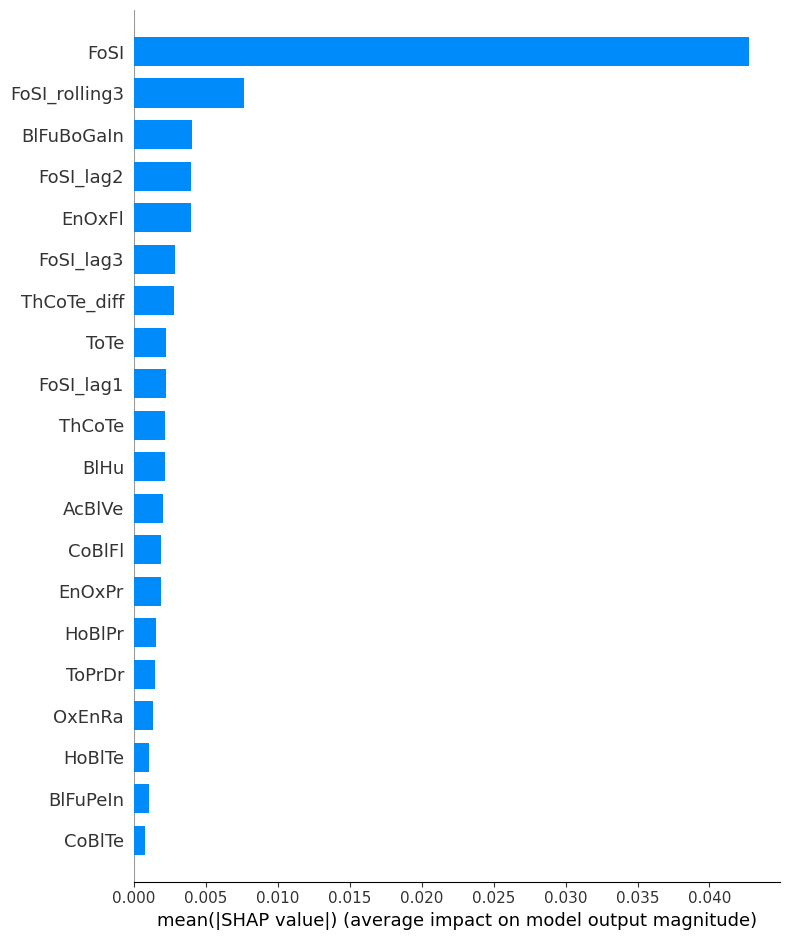

In [ ]:
# Initialize TreeExplainer with your trained model
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test, plot_type="bar")


Saving the Model Pickel File

In [14]:
joblib.dump(best_xgb, '../Models/SI_xgb_model.pkl')

['../Models/SI_xgb_model.pkl']

In [ ]:
# Recombine X_test and y_test into one DataFrame
test_df = X_test.copy()
test_df["SI"] = y_test.values  # Add actual target for comparison

# Save all test records to CSV
test_df.to_csv("../Data/sample_input.csv", index=False)
